# Tp3 : Mediciones de sensor de barrido láser 

1) Lanzamos Gazebo para simular el robot TurtleBot3 en el entorno mundo 

` roslaunch turtlebot3_gazebo turtlebot3_world.launch`

<img src="./imgs/turtlebot_world.png" alt="Gazebo" width="500" height = "500"/>

2) Lanzamos el nodo de teleoperación para mover el robot con el teclado 

` roslaunch turtlebot3_teleop turtlebot3_teleop_key.launch ` 

3) Ejecutamos la herramienta de registro de datos que crea un registro de odometría y puntos del sensor láser con extensión .bag . Rosbag permite grabar los mensajes de los tópicos que se le pasen por la línea de comandos

` rosbag record /cmd_vel /odom /scan ` 

En este caso, estaremos creando un registro del tópico de los **comando de velocidad**, de  **odometría** y **scan** que corresponde al sensor láser. 

El registro creado tiene de nombre **world.bag**


4) Descargamos el paquete de ROS para convertir el registro con extensión bag en texto plano. Para ello clonamos el repositorio en el espacio de trabajo de ROS (catkin_ws creado en práctico anteriores) 

```bash
    cd ~/catkin_ws/src  
    git clone https://github.com/ciiiutnfrc/rosbag2txt.git 
 ```   

  Después construimos el paquete con la herramienta `catkin_make`. Para comprobar que se ha construido exitosamente podemos corroborar: 
  
  ` rospack find rosbag2txt` 
  
 5) Convertimos el formato del archivo de texto: 
 
 `roslaunch rosbag2txt rosbag2txt.launch bagfile:=/home/<user>/world.bag`

   Realizamos ciertos **cambios** en el script por problemas de incompatibilidad con la versión de python en nuestra PC. 
 
 * La primer línea ` #!/usr/bin/env python` del script *odom_scan_log.py* la cambiamos por `#!/usr/bin/env python3 `. 
  
 * La línea 53 ` except rospy.ServiceException, e:` la cambiamos a ` except rospy.ServiceException as e:`

6) Cargamos los datos de scan.txt y graficamos 3 barridos laser 

In [173]:
import pandas as pd 
import matplotlib.pylab as plt
import numpy as np 

#El separador es un caracter de tab
# 
data = pd.read_csv("./log/scan.txt", sep= "\t", header=None, index_col = None) 
data = data.replace(np.inf,3.5) #El inf lo reemplazo por el valor máxima 
puntos  =[]
puntos.append(data.loc[0,1:])
puntos.append(data.loc[1,1:])
puntos.append(data.loc[2,1:])



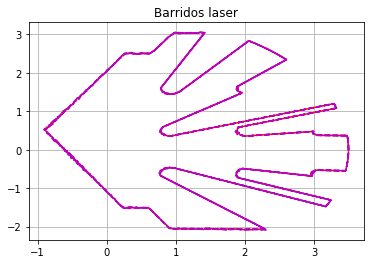

In [187]:
linea = ['r-', ':','m--']
ax  = [] 
ay = [] 
 
plt.figure()
plt.title("Barridos laser")
plt.grid('true')
for j in range(len(puntos)):
    for i,rho in enumerate(puntos[j]):
        res = 2*np.pi / 360 
        x = rho * np.cos(res*i)
        y = rho* np.sin(res*i)
        ax.append(x)
        ay.append(y)
    #plt.figure()
    plt.plot(ax,ay,linea[j])